In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Per game and advanced data combo

## Load, merge and filter data

In [2]:
per_game = pd.read_csv(Path('../data/per_game_data.csv'))
advanced = pd.read_csv(Path('../data/advanced_data.csv'))
advanced.drop(columns=['MP'], inplace=True)

data = per_game.merge(advanced, on=['Player', 'Pos', 'Age', 'Tm', 'G', 'season', 'all_nba_1st_team'])
data.dropna(axis=1, how='all', inplace=True)

data.shape

(8295, 51)

In [3]:
data.drop(columns=['Player', 'Pos', 'Age', 'Tm', 'season'], inplace=True)
data.drop(columns=['GS'], inplace=True)

data = data[data.G > 40]
data = data[data.MP > 25]

data.drop(columns=['FG%', '2P%', '3P%', 'FT%'], inplace=True)
data.drop(columns=['G', 'MP'], inplace=True)

data.shape

(2121, 39)

## Split and scale

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['all_nba_1st_team'])
y = data['all_nba_1st_team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=27, stratify=y)

In [5]:
from sklearn.preprocessing import StandardScaler

feature_names = X_train.columns

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score
from sklearn.dummy import DummyClassifier


def evaluate_model(estimator, X_test, y_test):
    y_predicted = estimator.predict(X_test)
    y_predicted_proba = estimator.predict_proba(X_test)

    print('confusion matrix:')
    print(confusion_matrix(y_test, y_predicted))
    print('-------------------------')
    print('classification report:')
    print(classification_report(y_test, y_predicted))
    print('-------------------------')
    print('roc auc score:', roc_auc_score(y_test, y_predicted))
    print('-------------------------')
    print('Log loss:', log_loss(y_test, y_predicted_proba)) # input for log loss are probabilities
    print('-------------------------')


### Without sampling

In [7]:
dummy = DummyClassifier(strategy='stratified', random_state=27)
dummy.fit(X_train, y_train)

evaluate_model(dummy, X_test, y_test)

confusion matrix:
[[674  13]
 [ 13   0]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       687
           1       0.00      0.00      0.00        13

    accuracy                           0.96       700
   macro avg       0.49      0.49      0.49       700
weighted avg       0.96      0.96      0.96       700

-------------------------
roc auc score: 0.49053857350800584
-------------------------
Log loss: 1.2828688375252546
-------------------------


In [8]:
svc = SVC(kernel='rbf', C=100, gamma=0.01, probability=True, random_state=27)
svc.fit(X_train, y_train)

evaluate_model(svc, X_test, y_test)

confusion matrix:
[[680   7]
 [  8   5]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.42      0.38      0.40        13

    accuracy                           0.98       700
   macro avg       0.70      0.69      0.69       700
weighted avg       0.98      0.98      0.98       700

-------------------------
roc auc score: 0.6872130780427723
-------------------------
Log loss: 0.051246543699827986
-------------------------


In [9]:
rfc = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc.fit(X_train, y_train)

evaluate_model(rfc, X_test, y_test)

confusion matrix:
[[687   0]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       687
           1       1.00      0.15      0.27        13

    accuracy                           0.98       700
   macro avg       0.99      0.58      0.63       700
weighted avg       0.98      0.98      0.98       700

-------------------------
roc auc score: 0.5769230769230769
-------------------------
Log loss: 0.03900321748515259
-------------------------


In [10]:
gbc = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features='sqrt', n_estimators=50, random_state=27)
gbc.fit(X_train, y_train)

evaluate_model(gbc, X_test, y_test)

confusion matrix:
[[687   0]
 [ 10   3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       1.00      0.23      0.38        13

    accuracy                           0.99       700
   macro avg       0.99      0.62      0.68       700
weighted avg       0.99      0.99      0.98       700

-------------------------
roc auc score: 0.6153846153846154
-------------------------
Log loss: 0.08588760314014046
-------------------------


## Undersampling

In [11]:
from imblearn.under_sampling import RandomUnderSampler

ratio = 1/4
rus = RandomUnderSampler(random_state=27, sampling_strategy=ratio)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_undersampled)

(array([1394,   27]), array([108,  27]))

In [12]:
dummy_undersampling = DummyClassifier(strategy='stratified', random_state=27)
dummy_undersampling.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(dummy_undersampling, X_test, y_test)

confusion matrix:
[[539 148]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       687
           1       0.01      0.15      0.02        13

    accuracy                           0.77       700
   macro avg       0.50      0.47      0.45       700
weighted avg       0.96      0.77      0.86       700

-------------------------
roc auc score: 0.4692083753219124
-------------------------
Log loss: 7.845236352558285
-------------------------


In [13]:
svc_undersampling = SVC(kernel='rbf', C=10, gamma=0.01, probability=True, random_state=27)
svc_undersampling.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(svc_undersampling, X_test, y_test)

confusion matrix:
[[642  45]
 [  1  12]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       687
           1       0.21      0.92      0.34        13

    accuracy                           0.93       700
   macro avg       0.60      0.93      0.65       700
weighted avg       0.98      0.93      0.95       700

-------------------------
roc auc score: 0.9287873698354048
-------------------------
Log loss: 0.12573161088123275
-------------------------


In [14]:
rfc_undersampling = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc_undersampling.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(rfc_undersampling, X_test, y_test)

confusion matrix:
[[657  30]
 [  2  11]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       687
           1       0.27      0.85      0.41        13

    accuracy                           0.95       700
   macro avg       0.63      0.90      0.69       700
weighted avg       0.98      0.95      0.97       700

-------------------------
roc auc score: 0.901242861941552
-------------------------
Log loss: 0.11192918451443337
-------------------------


In [15]:
gbc_undersampling = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features=None, n_estimators=50, random_state=27)
gbc_undersampling.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(gbc_undersampling, X_test, y_test)

confusion matrix:
[[650  37]
 [  1  12]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       687
           1       0.24      0.92      0.39        13

    accuracy                           0.95       700
   macro avg       0.62      0.93      0.68       700
weighted avg       0.98      0.95      0.96       700

-------------------------
roc auc score: 0.9346097861381704
-------------------------
Log loss: 0.2580423008318172
-------------------------


## Oversampling

In [16]:
from imblearn.over_sampling import RandomOverSampler

ratio = 1/4
ros = RandomOverSampler(random_state=27, sampling_strategy=ratio)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_oversampled)

(array([1394,   27]), array([1394,  348]))

In [17]:
dummy_oversampling = DummyClassifier(strategy='stratified', random_state=27)
dummy_oversampling.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(dummy_oversampling, X_test, y_test)

confusion matrix:
[[540 147]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       687
           1       0.01      0.15      0.02        13

    accuracy                           0.77       700
   macro avg       0.50      0.47      0.45       700
weighted avg       0.96      0.77      0.86       700

-------------------------
roc auc score: 0.4699361773597581
-------------------------
Log loss: 7.795895243422697
-------------------------


In [18]:
svc_oversampling = SVC(kernel='rbf', C=1, gamma='auto', probability=True, random_state=27)
svc_oversampling.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(svc_oversampling, X_test, y_test)

confusion matrix:
[[674  13]
 [  4   9]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       687
           1       0.41      0.69      0.51        13

    accuracy                           0.98       700
   macro avg       0.70      0.84      0.75       700
weighted avg       0.98      0.98      0.98       700

-------------------------
roc auc score: 0.8366924196618519
-------------------------
Log loss: 0.06786266930439692
-------------------------


In [19]:
rfc_oversampling = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc_oversampling.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(rfc_oversampling, X_test, y_test)

confusion matrix:
[[687   0]
 [ 10   3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       1.00      0.23      0.38        13

    accuracy                           0.99       700
   macro avg       0.99      0.62      0.68       700
weighted avg       0.99      0.99      0.98       700

-------------------------
roc auc score: 0.6153846153846154
-------------------------
Log loss: 0.037534838080846976
-------------------------


In [20]:
gbc_oversampling = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features=None, n_estimators=50, random_state=27)
gbc_oversampling.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(gbc_oversampling, X_test, y_test)

confusion matrix:
[[680   7]
 [ 10   3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.30      0.23      0.26        13

    accuracy                           0.98       700
   macro avg       0.64      0.61      0.62       700
weighted avg       0.97      0.98      0.97       700

-------------------------
roc auc score: 0.6102900011196954
-------------------------
Log loss: 0.1165399678509209
-------------------------


## SMOTE

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=27, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_resampled)

(array([1394,   27]), array([1394, 1394]))

In [22]:
dummy_smote = DummyClassifier(strategy='stratified', random_state=27)
dummy_smote.fit(X_train_resampled, y_train_resampled)

evaluate_model(dummy_smote, X_test, y_test)

confusion matrix:
[[340 347]
 [  6   7]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.49      0.66       687
           1       0.02      0.54      0.04        13

    accuracy                           0.50       700
   macro avg       0.50      0.52      0.35       700
weighted avg       0.96      0.50      0.65       700

-------------------------
roc auc score: 0.5166834620983092
-------------------------
Log loss: 17.417411524862104
-------------------------


In [23]:
svc_smote = SVC(kernel='rbf', C=0.1, gamma='scale', probability=True, random_state=27)
svc_smote.fit(X_train_resampled, y_train_resampled)

evaluate_model(svc_smote, X_test, y_test)

confusion matrix:
[[644  43]
 [  2  11]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       687
           1       0.20      0.85      0.33        13

    accuracy                           0.94       700
   macro avg       0.60      0.89      0.65       700
weighted avg       0.98      0.94      0.95       700

-------------------------
roc auc score: 0.8917814354495578
-------------------------
Log loss: 0.1304741686429175
-------------------------


In [24]:
rfc_smote = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=200, random_state=27)
rfc_smote.fit(X_train_resampled, y_train_resampled)

evaluate_model(rfc_smote, X_test, y_test)

confusion matrix:
[[671  16]
 [  3  10]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       687
           1       0.38      0.77      0.51        13

    accuracy                           0.97       700
   macro avg       0.69      0.87      0.75       700
weighted avg       0.98      0.97      0.98       700

-------------------------
roc auc score: 0.8729705520098533
-------------------------
Log loss: 0.06857270721882741
-------------------------


In [25]:
gbc_smote = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features='sqrt', n_estimators=300, random_state=27)
gbc_smote.fit(X_train_resampled, y_train_resampled)

evaluate_model(gbc_smote, X_test, y_test)

confusion matrix:
[[681   6]
 [ 10   3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.33      0.23      0.27        13

    accuracy                           0.98       700
   macro avg       0.66      0.61      0.63       700
weighted avg       0.97      0.98      0.98       700

-------------------------
roc auc score: 0.6110178031575412
-------------------------
Log loss: 0.18097078627355265
-------------------------


## Predict new data (2019-2020 season)

In [26]:
per_game_2020 = pd.read_csv(Path('../data/per_game_2020.csv'))
advanced_2020 = pd.read_csv(Path('../data/advanced_2020.csv'))

advanced_2020.drop(columns=['MP'], inplace=True)

data_2020 = per_game_2020.merge(advanced_2020, on=['Player', 'Pos', 'Age', 'Tm', 'G', 'season'])
data_2020.dropna(axis=1, how='all', inplace=True)

data_2020 = data_2020[data_2020.G > 40]
data_2020 = data_2020[data_2020.MP > 25]
# data_2020 = data_2020[data_2020.Pos == 'C']
data_2020 = data_2020[data_2020.Player.isin(['Anthony Davis', 'Nikola Jokić', 'Joel Embiid', 'Rudy Gobert'])]

player_names = data_2020['Player'].values
teams = data_2020['Tm'].values

data_2020.drop(columns=['Player', 'Pos', 'Age', 'Tm', 'season'], inplace=True)
data_2020.drop(columns=['GS'], inplace=True)

data_2020.drop(columns=['FG%', '2P%', '3P%', 'FT%'], inplace=True)
data_2020.drop(columns=['G', 'MP'], inplace=True)

data_2020 = scaler.transform(data_2020)

data_2020.shape

(4, 38)

In [27]:
svc_predictions = np.around([pred[1] for pred in svc.predict_proba(data_2020)], 3)
rfc_predictions = np.around([pred[1] for pred in rfc.predict_proba(data_2020)], 3)
gbc_predictions = np.around([pred[1] for pred in gbc.predict_proba(data_2020)], 3)

no_sampling_predictions = pd.DataFrame({
    'svc': svc_predictions,
    'rfc': rfc_predictions,
    'gbc': gbc_predictions
})

In [28]:
svc_undersampling_predictions = np.around([pred[1] for pred in svc_undersampling.predict_proba(data_2020)], 3)
rfc_undersampling_predictions = np.around([pred[1] for pred in rfc_undersampling.predict_proba(data_2020)], 3)
gbc_undersampling_predictions = np.around([pred[1] for pred in gbc_undersampling.predict_proba(data_2020)], 3)

undersampling_predictions = pd.DataFrame({
    'svc': svc_undersampling_predictions,
    'rfc': rfc_undersampling_predictions,
    'gbc': gbc_undersampling_predictions
})


In [29]:
svc_oversampling_predictions = np.around([pred[1] for pred in svc_oversampling.predict_proba(data_2020)], 3)
rfc_oversampling_predictions = np.around([pred[1] for pred in rfc_oversampling.predict_proba(data_2020)], 3)
gbc_oversampling_predictions = np.around([pred[1] for pred in gbc_oversampling.predict_proba(data_2020)], 3)

oversampling_predictions = pd.DataFrame({
    'svc': svc_oversampling_predictions,
    'rfc': rfc_oversampling_predictions,
    'gbc': gbc_oversampling_predictions
})


In [30]:
svc_smote_predictions = np.around([pred[1] for pred in svc_smote.predict_proba(data_2020)], 3)
rfc_smote_predictions = np.around([pred[1] for pred in rfc_smote.predict_proba(data_2020)], 3)
gbc_smote_predictions = np.around([pred[1] for pred in gbc_smote.predict_proba(data_2020)], 3)

smote_predictions = pd.DataFrame({
    'svc': svc_smote_predictions,
    'rfc': rfc_smote_predictions,
    'gbc': gbc_smote_predictions
})


## Voting and averages

In [31]:
no_sampling_predictions['mean ored'] = no_sampling_predictions.mean(axis=1)
undersampling_predictions['mean pred'] = undersampling_predictions.mean(axis=1)
oversampling_predictions['mean pred'] = oversampling_predictions.mean(axis=1)
smote_predictions['mean pred'] = smote_predictions.mean(axis=1)

In [32]:
from sklearn.ensemble import VotingClassifier

In [33]:
voting = VotingClassifier(
    [('svc', svc), ('rfc', rfc), ('gbc', gbc)],
    voting='soft',
    weights=[3.8 + 6.9, 1.5 + 5.8, 2.3 + 6.2]
).fit(X_train, y_train)

probs = np.round([prob[1] for prob in voting.predict_proba(data_2020)], 3)

no_sampling_predictions['voting pred'] = probs

In [34]:
no_sampling_predictions['player'] = player_names
no_sampling_predictions['team'] = teams

no_sampling_predictions

,svc,rfc,gbc,mean ored,voting pred,player,team
0,0.251,0.16,0.001,0.137333,0.146,Anthony Davis,LAL
1,0.042,0.12,0.001,0.054333,0.050,Joel Embiid,PHI
2,0.062,0.16,0.001,0.074333,0.069,Rudy Gobert,UTA
3,0.007,0.02,0.000,0.009000,0.008,Nikola Jokić,DEN


In [35]:
voting_undersampling = VotingClassifier(
    [('svc', svc_undersampling), ('rfc', rfc_undersampling), ('gbc', gbc_undersampling)],
    voting='soft',
    weights=[9.2 + 9.3, 8.5 + 9.0, 9.2 + 9.3]
).fit(X_train_undersampled, y_train_undersampled)

probs = np.round([prob[1] for prob in voting_undersampling.predict_proba(data_2020)], 3)

undersampling_predictions['voting pred'] = probs

In [36]:
undersampling_predictions['player'] = player_names
undersampling_predictions['team'] = teams

undersampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.507,0.54,0.078,0.375000,0.372,Anthony Davis,LAL
1,0.207,0.44,0.003,0.216667,0.213,Joel Embiid,PHI
2,0.623,0.60,0.001,0.408000,0.405,Rudy Gobert,UTA
3,0.361,0.38,0.127,0.289333,0.288,Nikola Jokić,DEN


In [37]:
voting_oversampling = VotingClassifier(
    [('svc', svc_oversampling), ('rfc', rfc_oversampling), ('gbc', gbc_oversampling)],
    voting='soft',
    weights=[6.9 + 8.4, 2.3 + 6.2, 2.3 + 6.1] # rac aur + recall
).fit(X_train_oversampled, y_train_oversampled)

probs = np.round([prob[1] for prob in voting_oversampling.predict_proba(data_2020)], 3)

oversampling_predictions['voting pred'] = probs

In [38]:
oversampling_predictions['player'] = player_names
oversampling_predictions['team'] = teams

oversampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.230,0.168,0.071,0.156333,0.172,Anthony Davis,LAL
1,0.001,0.039,0.021,0.020333,0.017,Joel Embiid,PHI
2,0.002,0.258,0.001,0.087000,0.070,Rudy Gobert,UTA
3,0.000,0.020,0.001,0.007000,0.006,Nikola Jokić,DEN


In [39]:
voting_smote = VotingClassifier(
    [('svc', svc_smote), ('rfc', rfc_smote), ('gbc', gbc_smote)],
    voting='soft',
    weights=[8.5 + 8.9, 7.7 + 8.7, 2.3 + 6.1]
).fit(X_train_resampled, y_train_resampled)

probs = np.round([prob[1] for prob in voting_smote.predict_proba(data_2020)], 3)

smote_predictions['voting pred'] = probs

In [40]:
smote_predictions['player'] = player_names
smote_predictions['team'] = teams

smote_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.571,0.316,0.009,0.298667,0.360,Anthony Davis,LAL
1,0.026,0.135,0.000,0.053667,0.063,Joel Embiid,PHI
2,0.265,0.471,0.000,0.245333,0.292,Rudy Gobert,UTA
3,0.002,0.040,0.000,0.014000,0.016,Nikola Jokić,DEN


### Averaging best models

In [41]:
svc_undersampling_predictions = np.around([pred[1] for pred in svc_undersampling.predict_proba(data_2020)], 3)
rfc_undersampling_predictions = np.around([pred[1] for pred in rfc_undersampling.predict_proba(data_2020)], 3)
gbc_undersampling_predictions = np.around([pred[1] for pred in gbc_undersampling.predict_proba(data_2020)], 3)
svc_smote_predictions = np.around([pred[1] for pred in svc_smote.predict_proba(data_2020)], 3)
rfc_smote_predictions = np.around([pred[1] for pred in rfc_smote.predict_proba(data_2020)], 3)

best_models_predictions = pd.DataFrame({
    'svc_undersampling': svc_undersampling_predictions,
    'rfc_undersampling': rfc_undersampling_predictions,
    'gbc_undersampling': gbc_undersampling_predictions,
    'svc_smote': svc_smote_predictions,
    'rfc_smote': rfc_smote_predictions
})

best_models_predictions['mean pred'] = best_models_predictions.mean(axis=1)
best_models_predictions['player'] = player_names

best_models_predictions

,svc_undersampling,rfc_undersampling,gbc_undersampling,svc_smote,rfc_smote,mean pred,player
0,0.507,0.54,0.078,0.571,0.316,0.4024,Anthony Davis
1,0.207,0.44,0.003,0.026,0.135,0.1622,Joel Embiid
2,0.623,0.60,0.001,0.265,0.471,0.3920,Rudy Gobert
3,0.361,0.38,0.127,0.002,0.040,0.1820,Nikola Jokić


## SHAP values

In [42]:
import shap
import matplotlib.pyplot as plt

def SHAP_values(model, X_train):
    k_sample = shap.kmeans(X_train, 5)
    explainer = shap.KernelExplainer(model.predict, k_sample)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)
    plt.show()

    shap.summary_plot(shap_values, X_train, plot_type='bar')
    plt.show()


In [43]:
# SHAP_values(svc, pd.DataFrame(data=X_train, columns=feature_names))

In [44]:
# SHAP_values(rfc, pd.DataFrame(data=X_train, columns=feature_names))

In [45]:
# SHAP_values(gbc, pd.DataFrame(data=X_train, columns=feature_names))

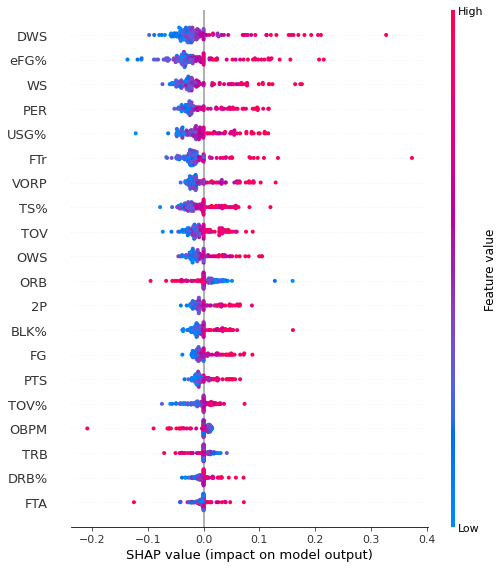

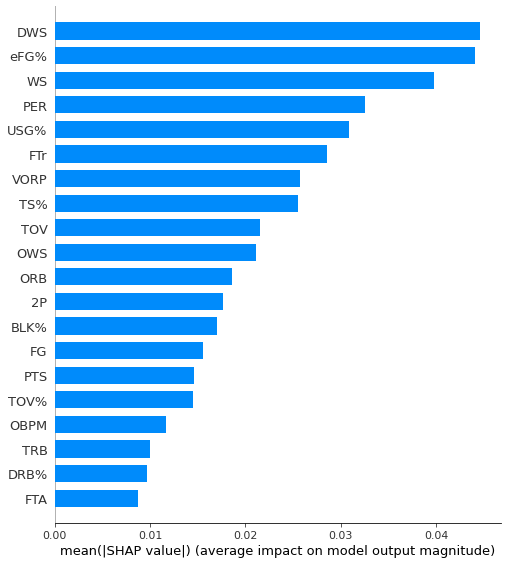

In [46]:
SHAP_values(svc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

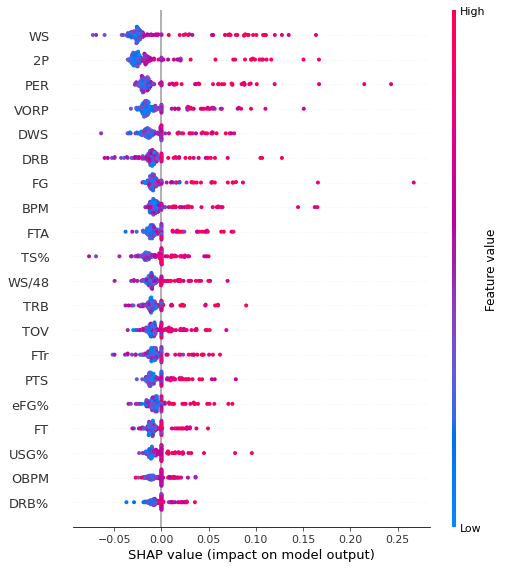

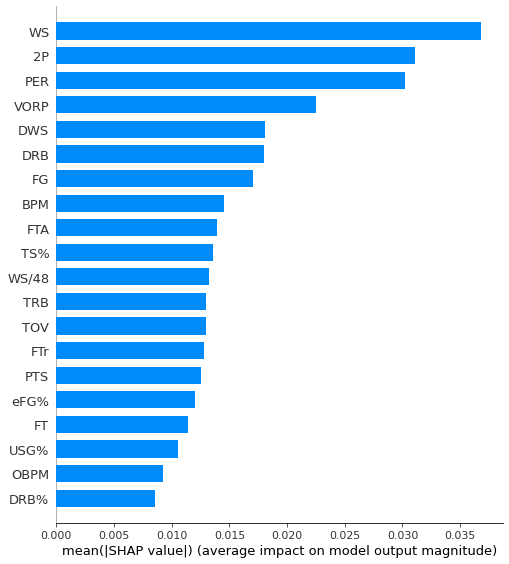

In [47]:
SHAP_values(rfc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

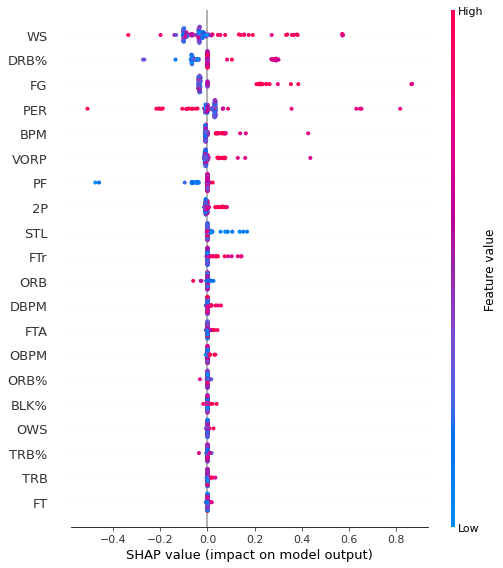

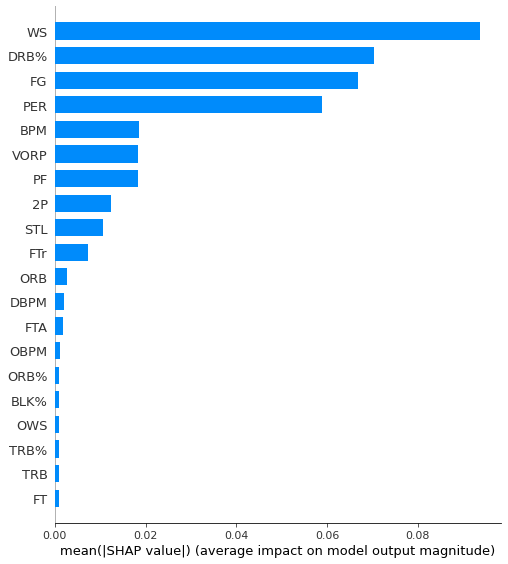

In [48]:
SHAP_values(gbc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

In [49]:
# SHAP_values(svc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [50]:
# SHAP_values(rfc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [51]:
# SHAP_values(gbc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

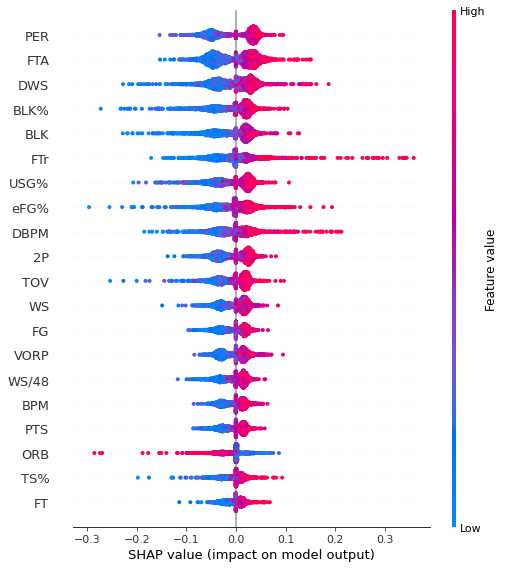

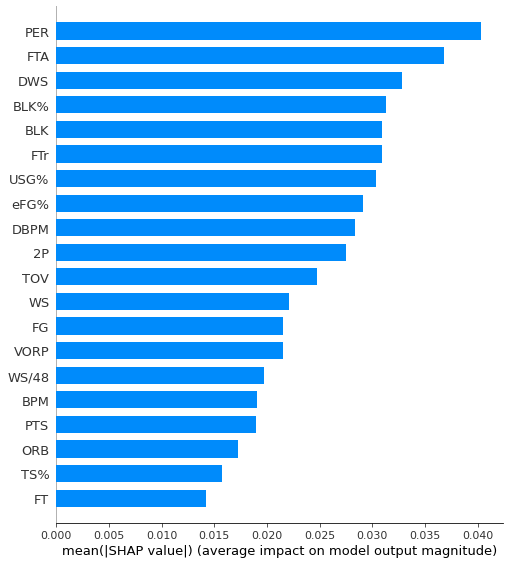

In [52]:
SHAP_values(svc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

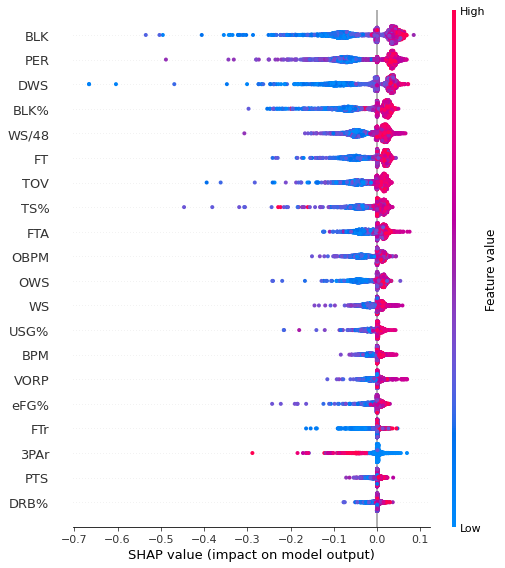

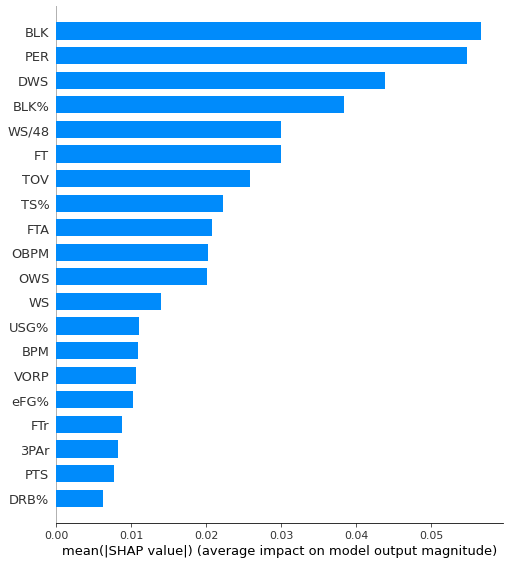

In [53]:
SHAP_values(rfc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

In [54]:
# SHAP_values(gbc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

# Per 100 and advanced data combo

# Load, merge and filter data

In [55]:
per_poss = pd.read_csv(Path('../data/per_100_data.csv'))
advanced = pd.read_csv(Path('../data/advanced_data.csv'))

data = per_poss.merge(advanced, on=['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'season', 'all_nba_1st_team'])
data.dropna(axis=1, how='all', inplace=True)

# transform minutes to per game stat instead of season total
data['MP'] = np.round(data['MP'] / data['G'], 1)

data.shape

(8295, 52)

In [56]:
data.drop(columns=['Player', 'Pos', 'Age', 'Tm', 'season'], inplace=True)
data.drop(columns=['GS'], inplace=True)

data = data[data.G > 40]
data = data[data.MP > 25]

data.drop(columns=['FG%', '2P%', '3P%', 'FT%'], inplace=True)
data.drop(columns=['G', 'MP'], inplace=True)

data.shape

(2121, 40)

## Split and scale

In [57]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['all_nba_1st_team'])
y = data['all_nba_1st_team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=27, stratify=y)

In [58]:
from sklearn.preprocessing import StandardScaler

feature_names = X_train.columns

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score
from sklearn.dummy import DummyClassifier


def evaluate_model(estimator, X_test, y_test):
    y_predicted = estimator.predict(X_test)
    y_predicted_proba = estimator.predict_proba(X_test)

    print('confusion matrix:')
    print(confusion_matrix(y_test, y_predicted))
    print('-------------------------')
    print('classification report:')
    print(classification_report(y_test, y_predicted))
    print('-------------------------')
    print('roc auc score:', roc_auc_score(y_test, y_predicted))
    print('-------------------------')
    print('Log loss:', log_loss(y_test, y_predicted_proba)) # input for log loss are probabilities
    print('-------------------------')


### Without sampling

In [60]:
dummy = DummyClassifier(strategy='stratified', random_state=27)
dummy.fit(X_train, y_train)

evaluate_model(dummy, X_test, y_test)

confusion matrix:
[[674  13]
 [ 13   0]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       687
           1       0.00      0.00      0.00        13

    accuracy                           0.96       700
   macro avg       0.49      0.49      0.49       700
weighted avg       0.96      0.96      0.96       700

-------------------------
roc auc score: 0.49053857350800584
-------------------------
Log loss: 1.2828688375252546
-------------------------


In [61]:
svc = SVC(kernel='rbf', C=1000, gamma=0.01, probability=True, random_state=27)
svc.fit(X_train, y_train)

evaluate_model(svc, X_test, y_test)

confusion matrix:
[[681   6]
 [  7   6]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.50      0.46      0.48        13

    accuracy                           0.98       700
   macro avg       0.74      0.73      0.74       700
weighted avg       0.98      0.98      0.98       700

-------------------------
roc auc score: 0.7264024185421566
-------------------------
Log loss: 0.053370405103998875
-------------------------


In [62]:
rfc = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc.fit(X_train, y_train)

evaluate_model(rfc, X_test, y_test)

confusion matrix:
[[687   0]
 [ 10   3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       1.00      0.23      0.38        13

    accuracy                           0.99       700
   macro avg       0.99      0.62      0.68       700
weighted avg       0.99      0.99      0.98       700

-------------------------
roc auc score: 0.6153846153846154
-------------------------
Log loss: 0.04042153013595087
-------------------------


In [63]:
gbc = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features=None, n_estimators=200, random_state=27)
gbc.fit(X_train, y_train)

evaluate_model(gbc, X_test, y_test)

confusion matrix:
[[677  10]
 [  7   6]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.38      0.46      0.41        13

    accuracy                           0.98       700
   macro avg       0.68      0.72      0.70       700
weighted avg       0.98      0.98      0.98       700

-------------------------
roc auc score: 0.7234912103907738
-------------------------
Log loss: 0.43083123282458474
-------------------------


## Undersampling

In [64]:
from imblearn.under_sampling import RandomUnderSampler

ratio = 1/4
rus = RandomUnderSampler(random_state=27, sampling_strategy=ratio)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_undersampled)

(array([1394,   27]), array([108,  27]))

In [65]:
dummy_undersampling = DummyClassifier(strategy='stratified', random_state=27)
dummy_undersampling.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(dummy_undersampling, X_test, y_test)

confusion matrix:
[[539 148]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       687
           1       0.01      0.15      0.02        13

    accuracy                           0.77       700
   macro avg       0.50      0.47      0.45       700
weighted avg       0.96      0.77      0.86       700

-------------------------
roc auc score: 0.4692083753219124
-------------------------
Log loss: 7.845236352558285
-------------------------


In [66]:
svc_undersampling = SVC(kernel='rbf', C=10, gamma=0.01, probability=True, random_state=27)
svc_undersampling.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(svc_undersampling, X_test, y_test)

confusion matrix:
[[634  53]
 [  1  12]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       687
           1       0.18      0.92      0.31        13

    accuracy                           0.92       700
   macro avg       0.59      0.92      0.63       700
weighted avg       0.98      0.92      0.95       700

-------------------------
roc auc score: 0.9229649535326391
-------------------------
Log loss: 0.1320353300399572
-------------------------


In [67]:
rfc_undersampling = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc_undersampling.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(rfc_undersampling, X_test, y_test)

confusion matrix:
[[663  24]
 [  1  12]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       687
           1       0.33      0.92      0.49        13

    accuracy                           0.96       700
   macro avg       0.67      0.94      0.74       700
weighted avg       0.99      0.96      0.97       700

-------------------------
roc auc score: 0.9440712126301646
-------------------------
Log loss: 0.10661229617519322
-------------------------


In [68]:
gbc_undersampling = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features='sqrt', n_estimators=50, random_state=27)
gbc_undersampling.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(gbc_undersampling, X_test, y_test)

confusion matrix:
[[666  21]
 [  4   9]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       687
           1       0.30      0.69      0.42        13

    accuracy                           0.96       700
   macro avg       0.65      0.83      0.70       700
weighted avg       0.98      0.96      0.97       700

-------------------------
roc auc score: 0.8308700033590863
-------------------------
Log loss: 0.08628596605242358
-------------------------


## Oversampling

In [69]:
from imblearn.over_sampling import RandomOverSampler

ratio = 1/4
ros = RandomOverSampler(random_state=27, sampling_strategy=ratio)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_oversampled)

(array([1394,   27]), array([1394,  348]))

In [70]:
dummy_oversampling = DummyClassifier(strategy='stratified', random_state=27)
dummy_oversampling.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(dummy_oversampling, X_test, y_test)

confusion matrix:
[[540 147]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       687
           1       0.01      0.15      0.02        13

    accuracy                           0.77       700
   macro avg       0.50      0.47      0.45       700
weighted avg       0.96      0.77      0.86       700

-------------------------
roc auc score: 0.4699361773597581
-------------------------
Log loss: 7.795895243422697
-------------------------


In [71]:
svc_oversampling = SVC(kernel='rbf', C=1, gamma=0.1, probability=True, random_state=27)
svc_oversampling.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(svc_oversampling, X_test, y_test)

confusion matrix:
[[685   2]
 [  9   4]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       0.67      0.31      0.42        13

    accuracy                           0.98       700
   macro avg       0.83      0.65      0.71       700
weighted avg       0.98      0.98      0.98       700

-------------------------
roc auc score: 0.6523905497704625
-------------------------
Log loss: 0.10148522194550436
-------------------------


In [72]:
rfc_oversampling = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50 , random_state=27)
rfc_oversampling.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(rfc_oversampling, X_test, y_test)

confusion matrix:
[[683   4]
 [  9   4]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.50      0.31      0.38        13

    accuracy                           0.98       700
   macro avg       0.74      0.65      0.69       700
weighted avg       0.98      0.98      0.98       700

-------------------------
roc auc score: 0.650934945694771
-------------------------
Log loss: 0.042347913301955066
-------------------------


In [73]:
gbc_oversampling = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features=None, n_estimators=50, random_state=27)
gbc_oversampling.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(gbc_oversampling, X_test, y_test)

confusion matrix:
[[682   5]
 [  9   4]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.44      0.31      0.36        13

    accuracy                           0.98       700
   macro avg       0.72      0.65      0.68       700
weighted avg       0.98      0.98      0.98       700

-------------------------
roc auc score: 0.6502071436569253
-------------------------
Log loss: 0.0943740770773927
-------------------------


## SMOTE

In [74]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=27, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_resampled)

(array([1394,   27]), array([1394, 1394]))

In [75]:
dummy_smote = DummyClassifier(strategy='stratified', random_state=27)
dummy_smote.fit(X_train_resampled, y_train_resampled)

evaluate_model(dummy_smote, X_test, y_test)

confusion matrix:
[[340 347]
 [  6   7]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.49      0.66       687
           1       0.02      0.54      0.04        13

    accuracy                           0.50       700
   macro avg       0.50      0.52      0.35       700
weighted avg       0.96      0.50      0.65       700

-------------------------
roc auc score: 0.5166834620983092
-------------------------
Log loss: 17.417411524862104
-------------------------


In [76]:
svc_smote = SVC(kernel='rbf', C=0.1, gamma=0.1, probability=True, random_state=27)
svc_smote.fit(X_train_resampled, y_train_resampled)

evaluate_model(svc_smote, X_test, y_test)

confusion matrix:
[[677  10]
 [  9   4]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.29      0.31      0.30        13

    accuracy                           0.97       700
   macro avg       0.64      0.65      0.64       700
weighted avg       0.97      0.97      0.97       700

-------------------------
roc auc score: 0.6465681334676969
-------------------------
Log loss: 0.1272299480853094
-------------------------


In [77]:
rfc_smote = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc_smote.fit(X_train_resampled, y_train_resampled)

evaluate_model(rfc_smote, X_test, y_test)

confusion matrix:
[[673  14]
 [  4   9]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       687
           1       0.39      0.69      0.50        13

    accuracy                           0.97       700
   macro avg       0.69      0.84      0.74       700
weighted avg       0.98      0.97      0.98       700

-------------------------
roc auc score: 0.8359646176240063
-------------------------
Log loss: 0.0705155680337699
-------------------------


In [78]:
gbc_smote = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features='sqrt', n_estimators=250, random_state=27)
gbc_smote.fit(X_train_resampled, y_train_resampled)

evaluate_model(gbc_smote, X_test, y_test)

confusion matrix:
[[679   8]
 [  9   4]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.33      0.31      0.32        13

    accuracy                           0.98       700
   macro avg       0.66      0.65      0.65       700
weighted avg       0.97      0.98      0.98       700

-------------------------
roc auc score: 0.6480237375433882
-------------------------
Log loss: 0.20163768784257977
-------------------------


## Predict new data (2019-2020 season)

In [79]:
per_game_2020 = pd.read_csv(Path('../data/per_100_2020.csv'))
advanced_2020 = pd.read_csv(Path('../data/advanced_2020.csv'))

advanced_2020.drop(columns=['MP'], inplace=True)

data_2020 = per_game_2020.merge(advanced_2020, on=['Player', 'Pos', 'Age', 'Tm', 'G', 'season'])
data_2020.dropna(axis=1, how='all', inplace=True)

data_2020['MP'] = np.round(data_2020['MP'] / data_2020['G'], 1)

data_2020 = data_2020[data_2020.G > 40]
data_2020 = data_2020[data_2020.MP > 25]
# data_2020 = data_2020[data_2020.Pos == 'C']
data_2020 = data_2020[data_2020.Player.isin(['Anthony Davis', 'Nikola Jokić', 'Joel Embiid', 'Rudy Gobert'])]

player_names = data_2020['Player'].values
teams = data_2020['Tm'].values

data_2020.drop(columns=['Player', 'Pos', 'Age', 'Tm', 'season'], inplace=True)
data_2020.drop(columns=['GS'], inplace=True)

data_2020.drop(columns=['FG%', '2P%', '3P%', 'FT%'], inplace=True)
data_2020.drop(columns=['G', 'MP'], inplace=True)

data_2020 = scaler.transform(data_2020)

data_2020.shape

(4, 39)

In [80]:
svc_predictions = np.around([pred[1] for pred in svc.predict_proba(data_2020)], 3)
rfc_predictions = np.around([pred[1] for pred in rfc.predict_proba(data_2020)], 3)
gbc_predictions = np.around([pred[1] for pred in gbc.predict_proba(data_2020)], 3)

no_sampling_predictions = pd.DataFrame({
    'svc': svc_predictions,
    'rfc': rfc_predictions,
    'gbc': gbc_predictions
})

In [81]:
svc_undersampling_predictions = np.around([pred[1] for pred in svc_undersampling.predict_proba(data_2020)], 3)
rfc_undersampling_predictions = np.around([pred[1] for pred in rfc_undersampling.predict_proba(data_2020)], 3)
gbc_undersampling_predictions = np.around([pred[1] for pred in gbc_undersampling.predict_proba(data_2020)], 3)

undersampling_predictions = pd.DataFrame({
    'svc': svc_undersampling_predictions,
    'rfc': rfc_undersampling_predictions,
    'gbc': gbc_undersampling_predictions
})


In [82]:
svc_oversampling_predictions = np.around([pred[1] for pred in svc_oversampling.predict_proba(data_2020)], 3)
rfc_oversampling_predictions = np.around([pred[1] for pred in rfc_oversampling.predict_proba(data_2020)], 3)
gbc_oversampling_predictions = np.around([pred[1] for pred in gbc_oversampling.predict_proba(data_2020)], 3)

oversampling_predictions = pd.DataFrame({
    'svc': svc_oversampling_predictions,
    'rfc': rfc_oversampling_predictions,
    'gbc': gbc_oversampling_predictions
})


In [83]:
svc_smote_predictions = np.around([pred[1] for pred in svc_smote.predict_proba(data_2020)], 3)
rfc_smote_predictions = np.around([pred[1] for pred in rfc_smote.predict_proba(data_2020)], 3)
gbc_smote_predictions = np.around([pred[1] for pred in gbc_smote.predict_proba(data_2020)], 3)

smote_predictions = pd.DataFrame({
    'svc': svc_smote_predictions,
    'rfc': rfc_smote_predictions,
    'gbc': gbc_smote_predictions
})


## Voting and averages

In [84]:
no_sampling_predictions['mean pred'] = no_sampling_predictions.mean(axis=1)
undersampling_predictions['mean pred'] = undersampling_predictions.mean(axis=1)
oversampling_predictions['mean pred'] = oversampling_predictions.mean(axis=1)
smote_predictions['mean pred'] = smote_predictions.mean(axis=1)

In [85]:
from sklearn.ensemble import VotingClassifier

In [86]:
voting = VotingClassifier(
    [('svc', svc), ('rfc', rfc), ('gbc', gbc)],
    voting='soft',
    weights=[4.6 + 7.3, 2.3 + 6.2, 4.6 + 7.2]
).fit(X_train, y_train)

probs = np.round([prob[1] for prob in voting.predict_proba(data_2020)], 3)

no_sampling_predictions['voting pred'] = probs

In [87]:
no_sampling_predictions['player'] = player_names
no_sampling_predictions['team'] = teams

no_sampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.258,0.160,0.0,0.139333,0.138,Anthony Davis,LAL
1,0.060,0.200,0.0,0.086667,0.075,Joel Embiid,PHI
2,0.025,0.000,0.0,0.008333,0.009,Rudy Gobert,UTA
3,0.003,0.035,0.0,0.012667,0.010,Nikola Jokić,DEN


In [88]:
voting_undersampling = VotingClassifier(
    [('svc', svc_undersampling), ('rfc', rfc_undersampling), ('gbc', gbc_undersampling)],
    voting='soft',
    weights=[9.2 + 9.2, 9.2 + 9.4, 6.9 + 8.3]
).fit(X_train_undersampled, y_train_undersampled)

probs = np.round([prob[1] for prob in voting_undersampling.predict_proba(data_2020)], 3)

undersampling_predictions['voting pred'] = probs

In [89]:
undersampling_predictions['player'] = player_names
undersampling_predictions['team'] = teams

undersampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.477,0.44,0.895,0.604000,0.586,Anthony Davis,LAL
1,0.227,0.38,0.047,0.218000,0.229,Joel Embiid,PHI
2,0.431,0.30,0.053,0.261333,0.274,Rudy Gobert,UTA
3,0.231,0.38,0.040,0.217000,0.228,Nikola Jokić,DEN


In [90]:
voting_oversampling = VotingClassifier(
    [('svc', svc_oversampling), ('rfc', rfc_oversampling), ('gbc', gbc_oversampling)],
    voting='soft',
    weights=[3.1 + 6.5, 3.1 + 6.5, 3.1 + 6.5]
).fit(X_train_oversampled, y_train_oversampled)

probs = np.round([prob[1] for prob in voting_oversampling.predict_proba(data_2020)], 3)

oversampling_predictions['voting pred'] = probs

In [91]:
oversampling_predictions['player'] = player_names
oversampling_predictions['team'] = teams

oversampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.0,0.157,0.985,0.380667,0.381,Anthony Davis,LAL
1,0.0,0.080,0.613,0.231000,0.231,Joel Embiid,PHI
2,0.0,0.100,0.001,0.033667,0.034,Rudy Gobert,UTA
3,0.0,0.020,0.001,0.007000,0.007,Nikola Jokić,DEN


In [92]:
voting_smote = VotingClassifier(
    [('svc', svc_smote), ('rfc', rfc_smote), ('gbc', gbc_smote)],
    voting='soft',
    weights=[3.1 + 6.5, 6.9 + 8.4, 3.1 + 6.5]
).fit(X_train_resampled, y_train_resampled)

probs = np.round([prob[1] for prob in voting_smote.predict_proba(data_2020)], 3)

smote_predictions['voting pred'] = probs

In [93]:
smote_predictions['player'] = player_names
smote_predictions['team'] = teams

smote_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.0,0.351,0.003,0.118000,0.156,Anthony Davis,LAL
1,0.0,0.179,0.000,0.059667,0.079,Joel Embiid,PHI
2,0.0,0.217,0.000,0.072333,0.096,Rudy Gobert,UTA
3,0.0,0.000,0.000,0.000000,0.000,Nikola Jokić,DEN


### Averaging best models

In [94]:
svc_undersampling_predictions = np.around([pred[1] for pred in svc_undersampling.predict_proba(data_2020)], 3)
rfc_undersampling_predictions = np.around([pred[1] for pred in rfc_undersampling.predict_proba(data_2020)], 3)
gbc_undersampling_predictions = np.around([pred[1] for pred in gbc_undersampling.predict_proba(data_2020)], 3)
rfc_smote_predictions = np.around([pred[1] for pred in rfc_smote.predict_proba(data_2020)], 3)

best_models_predictions = pd.DataFrame({
    'svc_undersampling': svc_undersampling_predictions,
    'rfc_undersampling': rfc_undersampling_predictions,
    'gbc_undersampling': gbc_undersampling_predictions,
    'rfc_smote': rfc_smote_predictions
})

best_models_predictions['mean pred'] = best_models_predictions.mean(axis=1)
best_models_predictions['player'] = player_names

best_models_predictions

,svc_undersampling,rfc_undersampling,gbc_undersampling,rfc_smote,mean pred,player
0,0.477,0.44,0.895,0.351,0.54075,Anthony Davis
1,0.227,0.38,0.047,0.179,0.20825,Joel Embiid
2,0.431,0.30,0.053,0.217,0.25025,Rudy Gobert
3,0.231,0.38,0.040,0.000,0.16275,Nikola Jokić


## SHAP values

In [95]:
import shap

def SHAP_values(model, X_train):
    k_sample = shap.kmeans(X_train, 5)
    explainer = shap.KernelExplainer(model.predict, k_sample)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)
    plt.show()
    
    shap.summary_plot(shap_values, X_train, plot_type='bar')
    plt.show()

In [96]:
# SHAP_values(svc, pd.DataFrame(data=X_train, columns=feature_names))

In [97]:
# SHAP_values(rfc, pd.DataFrame(data=X_train, columns=feature_names))

In [98]:
# SHAP_values(gbc, pd.DataFrame(data=X_train, columns=feature_names))

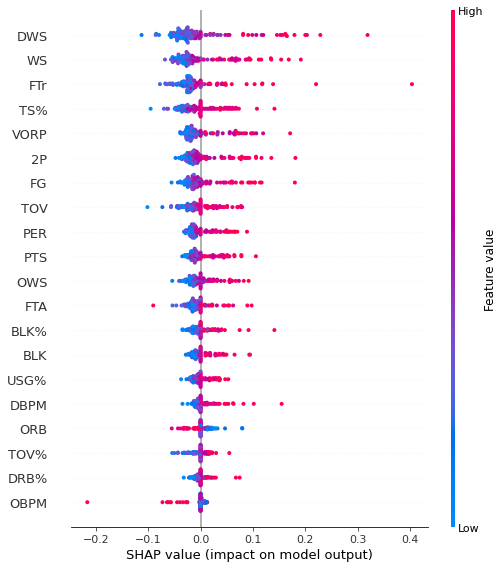

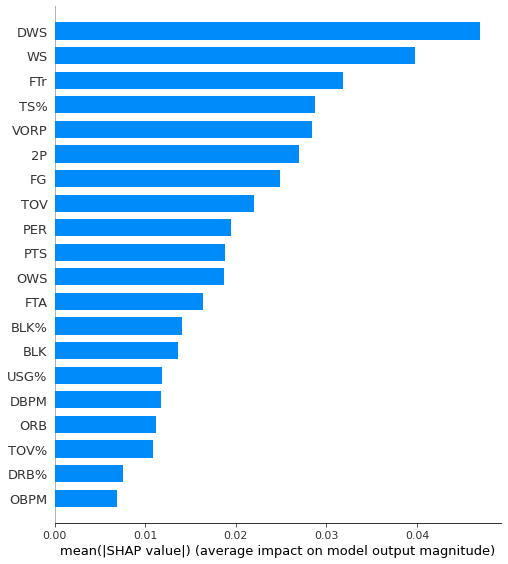

In [99]:
SHAP_values(svc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

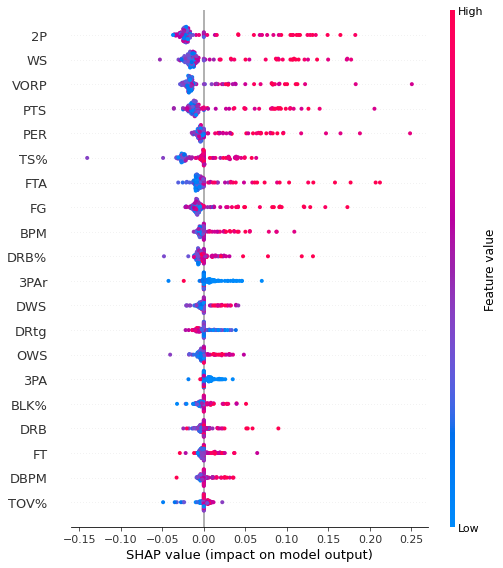

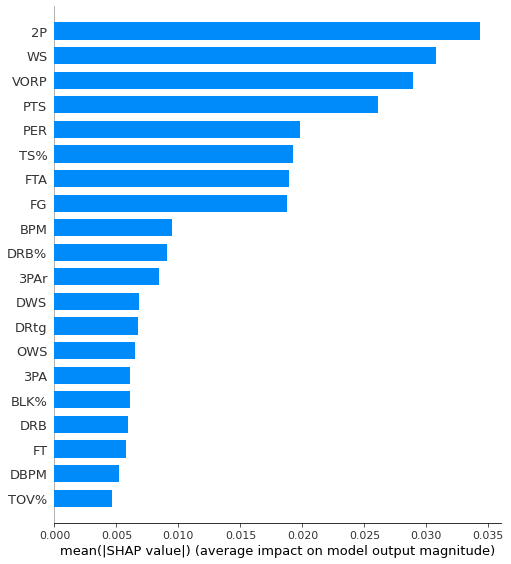

In [100]:
SHAP_values(rfc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

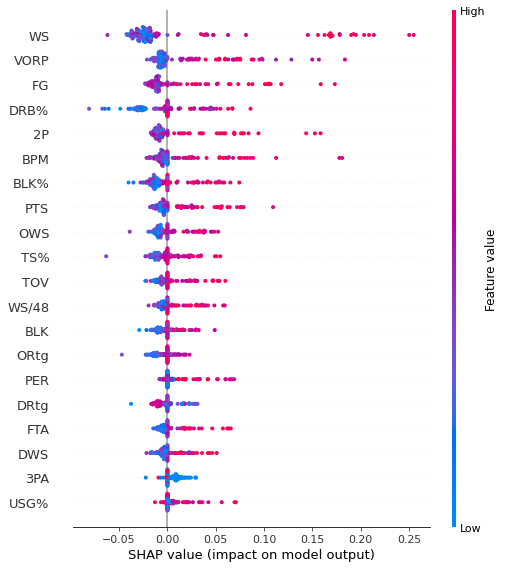

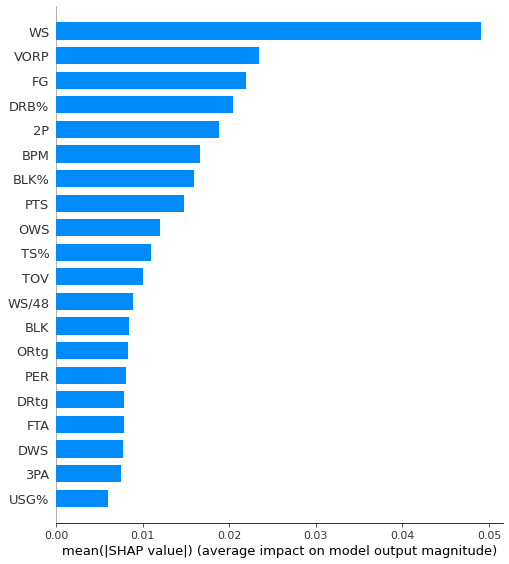

In [101]:
SHAP_values(gbc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

In [102]:
# SHAP_values(svc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [103]:
# SHAP_values(rfc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [104]:
# SHAP_values(gbc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [105]:
# SHAP_values(svc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

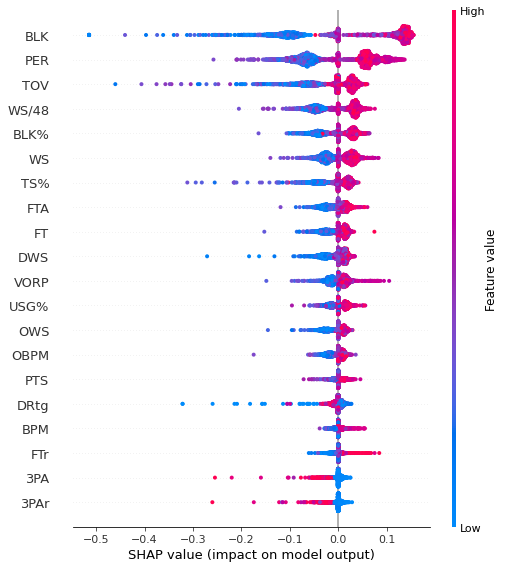

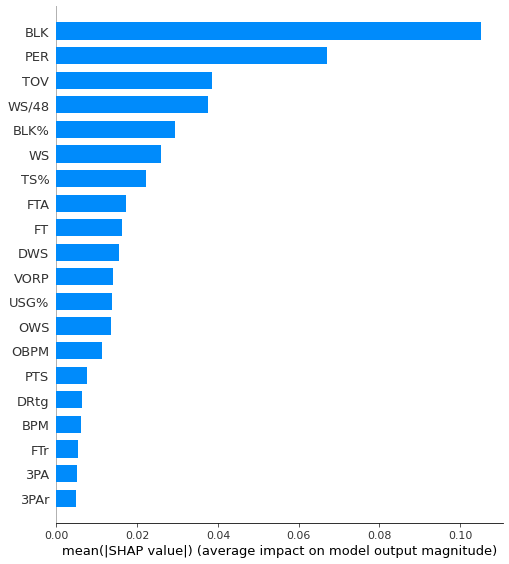

In [106]:
SHAP_values(rfc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

In [107]:
# SHAP_values(gbc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))